In [1]:
from reader import readShortVideo
from reader import getVideoList
import matplotlib.pyplot as plt
from os import listdir
import os
import pandas as pd
import numpy as np
import pickle

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


# read pre-defined feature and train RNN

In [2]:
with open("../features/train_features_d12.pkl", "rb") as f:
    train_features = pickle.load(f)
with open("../features/valid_features_d12.pkl", "rb") as f:
    valid_features = pickle.load(f)
    
with open("../features/train_y.pkl", "rb") as f:
    train_y = pickle.load(f)
with open("../features/valid_y.pkl", "rb") as f:
    valid_y = pickle.load(f)

In [55]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=512, n_layers=2, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_size =  hidden_size
        self.lstm = nn.LSTM(input_size, self.hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=False)
        self.bn_0 = nn.BatchNorm1d(self.hidden_size)
        self.fc_1 = nn.Linear(self.hidden_size, int(self.hidden_size/2))
        self.bn_1 = nn.BatchNorm1d(int(self.hidden_size/2))
        self.fc_2 = nn.Linear(int(self.hidden_size), 11)
        self.softmax = nn.Softmax(1)
        self.relu = nn.ReLU()
    def forward(self, padded_sequence, input_lengths, hidden=None):
        packed = torch.nn.utils.rnn.pack_padded_sequence(padded_sequence, input_lengths)
        outputs, (hn,cn) = self.lstm(packed, hidden) # output: (seq_len, batch, hidden*n_dir)
#         outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
#         outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs (1, batch, hidden)
        hidden_output = hn[-1]
        outputs = self.bn_0(hidden_output)
        outputs = self.softmax(self.fc_2(outputs))
        return outputs, hidden_output


In [58]:
def single_batch_padding(train_X_batch, train_y_batch, test = False):
    if test==True:
        padded_sequence = nn.utils.rnn.pad_sequence(train_X_batch)
        label = torch.LongTensor(train_y_batch)
        length = [len(train_X_batch[0])]
    else:
        length = [len(x) for x in train_X_batch]
        perm_index = np.argsort(length)[::-1]

        # sort by sequence length
        train_X_batch = [train_X_batch[i] for i in perm_index]
        length = [len(x) for x in train_X_batch]
        padded_sequence = nn.utils.rnn.pad_sequence(train_X_batch)
        label = torch.LongTensor(np.array(train_y_batch)[perm_index])
    return padded_sequence, label, length

In [59]:
input_valid_X, input_valid_y, valid_lengths = single_batch_padding([valid_features[0]], [valid_y[0]],
                                                                  test=True)

In [60]:
feature_size = 1024*7*7
model = LSTM(feature_size,hidden_size=512).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
BATCH_SIZE = 64
loss_function = nn.CrossEntropyLoss()
max_accuracy = 0
model.train()
training_loss = []
validation_acc = []
for epoch in range(20):
    print("Epoch:", epoch+1)
    CE_loss = 0.0
    total_length = len(train_features)
    # shuffle
    perm_index = np.random.permutation(len(train_features))
    train_X_sfl = [train_features[i] for i in perm_index]
    train_y_sfl = np.array(train_y)[perm_index]
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        optimizer.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        input_y = train_y_sfl[index:index+BATCH_SIZE]
        
        # pad the sequence
        input_X, input_y, length = single_batch_padding(input_X, input_y)
        
        # use GPU
        input_X = input_X.cuda()
        # forward + backward + optimize
        output, _ = model(input_X, length)
        loss = loss_function(output, input_y.cuda())
        loss.backward()
        optimizer.step()
        CE_loss += loss.cpu().data.numpy()
    print("training loss",CE_loss)
    training_loss.append(CE_loss)
    # validation
    same_difference = []
    with torch.no_grad():
        model.eval()
        for i in range(len(valid_y)):
            input_valid_X, input_valid_y, valid_lengths = single_batch_padding([valid_features[i]], 
                                                                               [valid_y[i]],
                                                                               test=True)
            output, _ = model(input_valid_X.cuda(),valid_lengths)
            output_label = torch.argmax(output,1).cpu().data
            same_difference.append((output_label == input_valid_y).numpy())
        accuracy = np.mean(same_difference)
        print("validation accuracy: ",accuracy)
        validation_acc.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        torch.save(model.state_dict(), "../models/RNN_FC_model.pkt")
    model.train()

Epoch: 1
training loss 116.71534419059753
validation accuracy:  0.2862669245647969
Epoch: 2
training loss 108.33542108535767
validation accuracy:  0.3984526112185687
Epoch: 3
training loss 103.18296647071838
validation accuracy:  0.44294003868471954
Epoch: 4
training loss 99.90852642059326
validation accuracy:  0.4526112185686654
Epoch: 5
training loss 96.56087934970856
validation accuracy:  0.4584139264990329
Epoch: 6
training loss 93.673828125
validation accuracy:  0.4796905222437137
Epoch: 7
training loss 91.33882987499237
validation accuracy:  0.4932301740812379
Epoch: 8
training loss 89.41459107398987
validation accuracy:  0.5029013539651838
Epoch: 9
training loss 87.83047485351562
validation accuracy:  0.4874274661508704
Epoch: 10
training loss 86.64102947711945
validation accuracy:  0.504835589941973
Epoch: 11
training loss 85.7450761795044
validation accuracy:  0.5009671179883946
Epoch: 12
training loss 85.02230870723724
validation accuracy:  0.48936170212765956
Epoch: 13
train

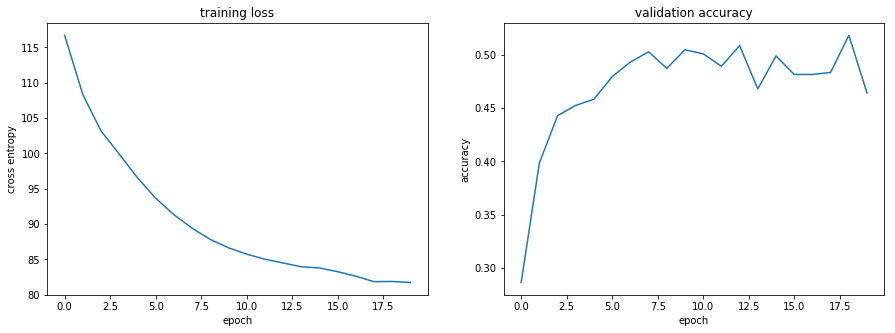

In [61]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.title("training loss")
plt.ylabel("cross entropy")
plt.xlabel("epoch")
plt.subplot(1,2,2)
plt.plot(validation_acc)
plt.title("validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.savefig("p2_curve.png")
plt.show()

# t-SNE visualization

In [62]:
from sklearn.manifold import TSNE

In [63]:
# CNN feature 
valid_features[1].shape
CNN_feautures = []
for seq_feature in valid_features:
    CNN_feautures.append(torch.mean(valid_features[1],0).numpy())
CNN_features = np.array(CNN_feautures)

In [64]:
CNN_features.shape

(517, 50176)

In [65]:
valid_y

[0,
 7,
 6,
 5,
 2,
 3,
 3,
 0,
 3,
 0,
 3,
 6,
 2,
 9,
 9,
 6,
 2,
 7,
 7,
 3,
 3,
 0,
 2,
 2,
 9,
 6,
 0,
 0,
 5,
 9,
 5,
 2,
 3,
 6,
 2,
 3,
 6,
 2,
 3,
 3,
 5,
 7,
 5,
 0,
 0,
 2,
 3,
 0,
 0,
 5,
 4,
 0,
 7,
 0,
 0,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 9,
 6,
 6,
 6,
 0,
 7,
 2,
 5,
 5,
 5,
 3,
 3,
 5,
 5,
 3,
 5,
 3,
 3,
 0,
 2,
 5,
 2,
 3,
 6,
 5,
 2,
 3,
 9,
 4,
 5,
 3,
 7,
 5,
 7,
 5,
 7,
 2,
 7,
 0,
 1,
 6,
 7,
 5,
 3,
 0,
 6,
 3,
 10,
 10,
 10,
 10,
 10,
 1,
 6,
 5,
 2,
 7,
 5,
 5,
 5,
 7,
 7,
 3,
 5,
 5,
 7,
 7,
 3,
 7,
 2,
 5,
 5,
 5,
 3,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 3,
 7,
 5,
 5,
 5,
 6,
 0,
 3,
 0,
 9,
 9,
 5,
 0,
 2,
 3,
 3,
 5,
 2,
 5,
 3,
 10,
 10,
 0,
 3,
 6,
 6,
 5,
 6,
 6,
 5,
 2,
 3,
 3,
 5,
 2,
 3,
 0,
 3,
 5,
 0,
 5,
 1,
 3,
 3,
 3,
 7,
 3,
 5,
 2,
 3,
 2,
 9,
 5,
 2,
 3,
 6,
 2,
 3,
 9,
 5,
 5,
 6,
 2,
 6,
 2,
 5,
 3,
 6,
 0,
 6,
 5,
 3,
 3,
 5,
 0,
 3,
 9,
 6,
 9,
 5,
 3,
 3,
 8,
 2,
 5,
 3,
 7,
 5,
 3,
 2,
 3,
 10,
 5,
 3,
 2,
 0,
 5,
 9,
 5,
 5,
 3,
 2,
 3,
 4,
 5,


In [66]:
CNN_features_2d = TSNE(n_components=2, perplexity=30.0, random_state=38).fit_transform(CNN_features)

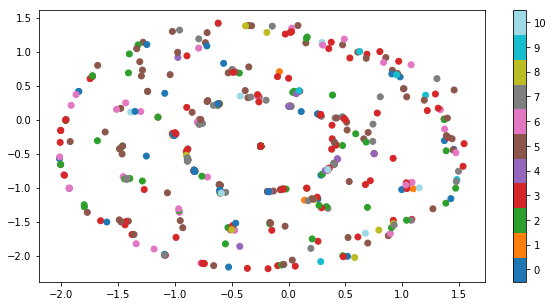

In [99]:
cm = plt.cm.get_cmap("tab20", 11)
plt.figure(figsize=(10,5))
plt.scatter(CNN_features_2d[:,0], CNN_features_2d[:,1], c=valid_y, cmap=cm)
plt.colorbar(ticks=range(11))
plt.clim(-0.5, 10.5)
plt.savefig("CNN_tsne.png")
plt.show()

In [69]:
# RNN feature 
model

LSTM(
  (lstm): LSTM(50176, 512, num_layers=2, dropout=0.5)
  (bn_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=512, out_features=256, bias=True)
  (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=512, out_features=11, bias=True)
  (softmax): Softmax()
  (relu): ReLU()
)

In [86]:
model.eval()
RNN_feautures = []
for i in range(len(valid_y)):
    input_valid_X, input_valid_y, valid_lengths = single_batch_padding([valid_features[i]], 
                                                                       [valid_y[i]],
                                                                       test=True)
    _, RNN_hidden = model(input_valid_X.cuda(),valid_lengths)
    RNN_feautures.append(RNN_hidden.cpu().data.numpy().reshape(-1))
RNN_feautures = np.array(RNN_feautures)

In [102]:
RNN_feautures_2d = TSNE(n_components=2, perplexity=80.0, random_state=38).fit_transform(RNN_feautures)

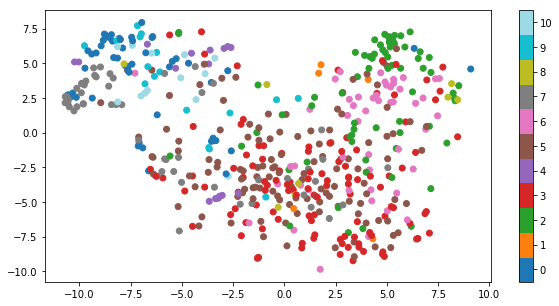

In [103]:
cm = plt.cm.get_cmap("tab20", 11)
plt.figure(figsize=(10,5))
plt.scatter(RNN_feautures_2d[:,0], RNN_feautures_2d[:,1], c=valid_y, cmap=cm)
plt.colorbar(ticks=range(11))
plt.clim(-0.5, 10.5)
plt.savefig("RNN_tsne.png")
plt.show()

In [97]:
print("Look up table for class color and genres:")
action = ["Other","Inspect/Read","Open","Take","Cut",
          "Put","Close","Move Around","Divide/Pull","Pour",
          "Transfer"]
pd.DataFrame({"genres":action}, index=list(range(11)))

Look up table for class color and genres:


,genres
0,Other
1,Inspect/Read
2,Open
3,Take
4,Cut
5,Put
6,Close
7,Move Around
8,Divide/Pull
9,Pour
